In [76]:
from __future__ import print_function
import keras
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
import numpy as np
import os
import matplotlib.pyplot as plt
import optuna

In [59]:
# Defining the parameters
batch_size = 32
num_classes = 10


# Splitting the data between train and test
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


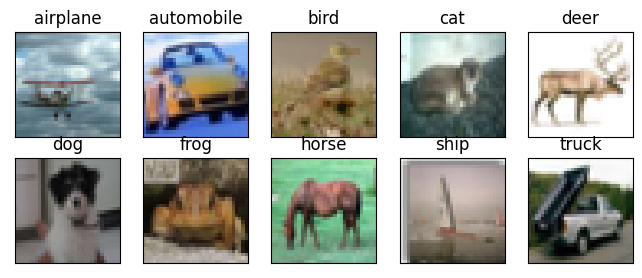

In [60]:
# plotting some random 10 images
class_names = ['airplane',
               'automobile',
               'bird',
               'cat',
               'deer',
               'dog',
               'frog',
               'horse',
               'ship',
               'truck']

fig = plt.figure(figsize=(8, 3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx, ::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num, ::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [61]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the input image
x_train /= 255
x_test /= 255


In [62]:
print(x_train.shape)

(50000, 32, 32, 3)


In [96]:
params = {
#     'learning_rate': 0.01, 
          'dropout': 0.25, 'conv1_num': 64, 'conv2_num': 128, 'fcl_num': 512, 'max_pooling': 2}
def create_model(conv1_num, conv2_num, fcl_num, max_pooling, learning_rate, dropout):
    model = Sequential()
    model.add(Conv2D(conv1_num, (3, 3), 
                     padding='same',
                     activation='relu',
                     input_shape=x_train.shape[1:]))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(max_pooling, max_pooling)))
    model.add(Dropout(dropout))


    model.add(Conv2D(conv2_num, (3, 3),  activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(max_pooling, max_pooling)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(fcl_num, kernel_regularizer=l2(learning_rate)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    epochs = 1  # 50

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

    
    return learning_rate, history
# model, history = create_model(**params)
h_list = []
for i in [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]:
    h_list.append(create_model(**params, learning_rate = i))

1563/1563 [==============================] - 203s 129ms/step - loss: 17.4655 - accuracy: 0.4006 - val_loss: 2.0304 - val_accuracy: 0.4599


[(0.001, <keras.callbacks.History object at 0x160d3dea0>), (0.01, <keras.callbacks.History object at 0x160864e20>), (0.1, <keras.callbacks.History object at 0x160230070>), (0.2, <keras.callbacks.History object at 0x160896e60>), (0.3, <keras.callbacks.History object at 0x15fc3a7a0>), (0.4, <keras.callbacks.History object at 0x15daa4430>), (0.5, <keras.callbacks.History object at 0x15fc73f40>)]


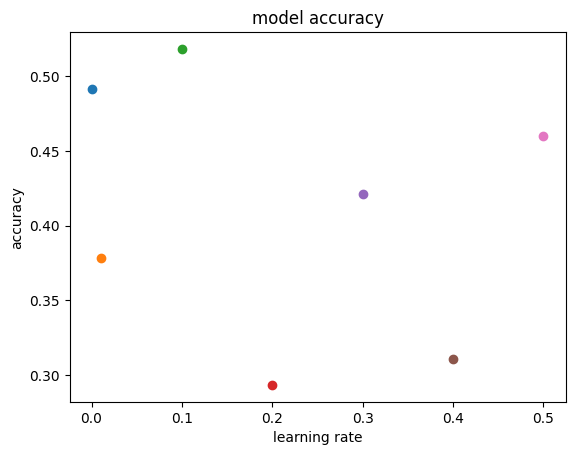

In [106]:
# print(history.history['val_accuracy'])
print(h_list)

# summarize history for accuracy
for n in h_list:
    plt.scatter(n[0], n[1].history['val_accuracy'])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('learning rate')
# plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_acc1.png')

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('model_loss1.png')




In [84]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'dropout': trial.suggest_float('dropout', 0.0, 0.4),
        'conv1_num': trial.suggest_int('conv1_num', 10, 100),
        'conv2_num': trial.suggest_int('conv2_num', 40, 200),
        'fcl_num': trial.suggest_int('fcl_num', 200, 700),
        'max_pooling': trial.suggest_int('max_pooling', 2, 4)
    }

    model, history = create_model(
        conv1_num=params['conv1_num'],
        conv2_num=params['conv2_num'],
        fcl_num=params['fcl_num'],
        max_pooling=params['max_pooling'],
        learning_rate=params['learning_rate'],
        dropout=params['dropout']
    )
    return history.history['accuracy'][-1]

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

[I 2022-11-01 15:55:17,553] A new study created in memory with name: no-name-3bb3c50f-75f4-4434-ba7f-5dfb5a9125c7


1563/1563 [==============================] - 150s 96ms/step - loss: 13.8588 - accuracy: 0.3895 - val_loss: 2.0745 - val_accuracy: 0.5118


[I 2022-11-01 15:57:50,639] Trial 0 finished with value: 0.3894599974155426 and parameters: {'learning_rate': 0.0863640065033642, 'dropout': 0.36454275029132865, 'conv1_num': 16, 'conv2_num': 189, 'fcl_num': 386, 'max_pooling': 2}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 78s 49ms/step - loss: 7.0770 - accuracy: 0.2981 - val_loss: 2.1610 - val_accuracy: 0.4326


[I 2022-11-01 15:59:09,669] Trial 1 finished with value: 0.29809999465942383 and parameters: {'learning_rate': 0.05908572606748318, 'dropout': 0.28375332313814516, 'conv1_num': 36, 'conv2_num': 198, 'fcl_num': 208, 'max_pooling': 3}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 96s 61ms/step - loss: 2.6780 - accuracy: 0.3298 - val_loss: 2.2321 - val_accuracy: 0.4065


[I 2022-11-01 16:00:47,352] Trial 2 finished with value: 0.3297800123691559 and parameters: {'learning_rate': 0.013182514764552636, 'dropout': 0.08111342885728444, 'conv1_num': 66, 'conv2_num': 52, 'fcl_num': 582, 'max_pooling': 4}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 88s 54ms/step - loss: 4.5291 - accuracy: 0.2936 - val_loss: 2.2711 - val_accuracy: 0.4173


[I 2022-11-01 16:02:16,984] Trial 3 finished with value: 0.2935999929904938 and parameters: {'learning_rate': 0.03859685650657093, 'dropout': 0.23028226911086716, 'conv1_num': 57, 'conv2_num': 117, 'fcl_num': 394, 'max_pooling': 4}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 115s 73ms/step - loss: 3.8619 - accuracy: 0.2835 - val_loss: 2.4126 - val_accuracy: 0.3335


[I 2022-11-01 16:04:12,637] Trial 4 finished with value: 0.28352001309394836 and parameters: {'learning_rate': 0.03177051394198884, 'dropout': 0.231959017450391, 'conv1_num': 92, 'conv2_num': 101, 'fcl_num': 227, 'max_pooling': 4}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 144s 92ms/step - loss: 10.7886 - accuracy: 0.3879 - val_loss: 2.1069 - val_accuracy: 0.4662


[I 2022-11-01 16:06:37,757] Trial 5 finished with value: 0.387939989566803 and parameters: {'learning_rate': 0.08309194283892217, 'dropout': 0.34923945412101853, 'conv1_num': 49, 'conv2_num': 108, 'fcl_num': 293, 'max_pooling': 2}. Best is trial 0 with value: 0.3894599974155426.


1563/1563 [==============================] - 118s 75ms/step - loss: 17.9576 - accuracy: 0.4143 - val_loss: 2.0743 - val_accuracy: 0.4987


[I 2022-11-01 16:08:37,535] Trial 6 finished with value: 0.41429999470710754 and parameters: {'learning_rate': 0.09395634234888497, 'dropout': 0.23892966385863548, 'conv1_num': 11, 'conv2_num': 155, 'fcl_num': 536, 'max_pooling': 2}. Best is trial 6 with value: 0.41429999470710754.


1563/1563 [==============================] - 188s 120ms/step - loss: 9.0332 - accuracy: 0.3244 - val_loss: 4.3229 - val_accuracy: 0.4547


[I 2022-11-01 16:11:47,523] Trial 7 finished with value: 0.3243800103664398 and parameters: {'learning_rate': 0.02655148094204611, 'dropout': 0.2978570723539173, 'conv1_num': 99, 'conv2_num': 170, 'fcl_num': 467, 'max_pooling': 3}. Best is trial 6 with value: 0.41429999470710754.


1563/1563 [==============================] - 63s 40ms/step - loss: 5.0578 - accuracy: 0.3679 - val_loss: 1.7893 - val_accuracy: 0.4187


[I 2022-11-01 16:12:52,350] Trial 8 finished with value: 0.36792001128196716 and parameters: {'learning_rate': 0.08601588698491068, 'dropout': 0.01146125975409067, 'conv1_num': 35, 'conv2_num': 123, 'fcl_num': 627, 'max_pooling': 4}. Best is trial 6 with value: 0.41429999470710754.


1563/1563 [==============================] - 49s 31ms/step - loss: 7.0185 - accuracy: 0.2797 - val_loss: 2.6027 - val_accuracy: 0.3079


[I 2022-11-01 16:13:42,082] Trial 9 finished with value: 0.2796599864959717 and parameters: {'learning_rate': 0.05229444526561197, 'dropout': 0.3527736261307042, 'conv1_num': 20, 'conv2_num': 133, 'fcl_num': 236, 'max_pooling': 3}. Best is trial 6 with value: 0.41429999470710754.


1563/1563 [==============================] - 252s 161ms/step - loss: 22.1746 - accuracy: 0.4556 - val_loss: 2.5340 - val_accuracy: 0.3972


[I 2022-11-01 16:17:54,922] Trial 10 finished with value: 0.4555799961090088 and parameters: {'learning_rate': 0.0999068851336027, 'dropout': 0.14366434827287558, 'conv1_num': 70, 'conv2_num': 153, 'fcl_num': 693, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 339s 216ms/step - loss: 22.0969 - accuracy: 0.4549 - val_loss: 2.0978 - val_accuracy: 0.5101


[I 2022-11-01 16:23:34,803] Trial 11 finished with value: 0.4548799991607666 and parameters: {'learning_rate': 0.09605563290900723, 'dropout': 0.14629693052815185, 'conv1_num': 78, 'conv2_num': 155, 'fcl_num': 689, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 292s 186ms/step - loss: 22.0761 - accuracy: 0.4536 - val_loss: 3.1127 - val_accuracy: 0.4455


[I 2022-11-01 16:28:30,615] Trial 12 finished with value: 0.45361998677253723 and parameters: {'learning_rate': 0.06934803066425098, 'dropout': 0.14552890040393993, 'conv1_num': 78, 'conv2_num': 154, 'fcl_num': 700, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 209s 133ms/step - loss: 19.9767 - accuracy: 0.4547 - val_loss: 2.4130 - val_accuracy: 0.3894


[I 2022-11-01 16:32:00,410] Trial 13 finished with value: 0.4547399878501892 and parameters: {'learning_rate': 0.09974840434256313, 'dropout': 0.14636039796981445, 'conv1_num': 79, 'conv2_num': 80, 'fcl_num': 665, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 250s 159ms/step - loss: 17.7044 - accuracy: 0.4482 - val_loss: 2.9188 - val_accuracy: 0.4186


[I 2022-11-01 16:36:10,963] Trial 14 finished with value: 0.4481799900531769 and parameters: {'learning_rate': 0.07078076305639738, 'dropout': 0.13747536181872833, 'conv1_num': 76, 'conv2_num': 145, 'fcl_num': 540, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 113s 72ms/step - loss: 12.1180 - accuracy: 0.3959 - val_loss: 2.1775 - val_accuracy: 0.4702


[I 2022-11-01 16:38:06,250] Trial 15 finished with value: 0.3958800137042999 and parameters: {'learning_rate': 0.07083397949318486, 'dropout': 0.059072065960900394, 'conv1_num': 64, 'conv2_num': 173, 'fcl_num': 623, 'max_pooling': 3}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 329s 210ms/step - loss: 5.0909 - accuracy: 0.4419 - val_loss: 4.4547 - val_accuracy: 0.5454


[I 2022-11-01 16:43:36,396] Trial 16 finished with value: 0.44185999035835266 and parameters: {'learning_rate': 0.0029227282268915744, 'dropout': 0.1699109988825701, 'conv1_num': 88, 'conv2_num': 180, 'fcl_num': 700, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 94s 60ms/step - loss: 8.4418 - accuracy: 0.3734 - val_loss: 1.9433 - val_accuracy: 0.3662


[I 2022-11-01 16:45:11,275] Trial 17 finished with value: 0.37338000535964966 and parameters: {'learning_rate': 0.0945471607506616, 'dropout': 0.10714046091868679, 'conv1_num': 45, 'conv2_num': 87, 'fcl_num': 516, 'max_pooling': 3}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 230s 147ms/step - loss: 19.5389 - accuracy: 0.4515 - val_loss: 2.3157 - val_accuracy: 0.5417


[I 2022-11-01 16:49:03,726] Trial 18 finished with value: 0.4514800012111664 and parameters: {'learning_rate': 0.07798915973244414, 'dropout': 0.1907401712037852, 'conv1_num': 68, 'conv2_num': 139, 'fcl_num': 606, 'max_pooling': 2}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 194s 123ms/step - loss: 10.1567 - accuracy: 0.3997 - val_loss: 2.3611 - val_accuracy: 0.4501


[I 2022-11-01 16:52:18,642] Trial 19 finished with value: 0.3997200131416321 and parameters: {'learning_rate': 0.061838498438057415, 'dropout': 0.04426856910221774, 'conv1_num': 87, 'conv2_num': 158, 'fcl_num': 470, 'max_pooling': 3}. Best is trial 10 with value: 0.4555799961090088.


1563/1563 [==============================] - 315s 200ms/step - loss: 20.7211 - accuracy: 0.4671 - val_loss: 2.4838 - val_accuracy: 0.3781


[I 2022-11-01 16:57:40,139] Trial 20 finished with value: 0.46709999442100525 and parameters: {'learning_rate': 0.09767429783801687, 'dropout': 0.09776686779964344, 'conv1_num': 100, 'conv2_num': 130, 'fcl_num': 652, 'max_pooling': 2}. Best is trial 20 with value: 0.46709999442100525.


1563/1563 [==============================] - 291s 186ms/step - loss: 20.8852 - accuracy: 0.4620 - val_loss: 1.9405 - val_accuracy: 0.5467


[I 2022-11-01 17:02:34,178] Trial 21 finished with value: 0.46202000975608826 and parameters: {'learning_rate': 0.0994754145721236, 'dropout': 0.10740190027474239, 'conv1_num': 98, 'conv2_num': 131, 'fcl_num': 657, 'max_pooling': 2}. Best is trial 20 with value: 0.46709999442100525.


1563/1563 [==============================] - 279s 178ms/step - loss: 20.7464 - accuracy: 0.4581 - val_loss: 2.2079 - val_accuracy: 0.5097


[I 2022-11-01 17:07:15,063] Trial 22 finished with value: 0.45809999108314514 and parameters: {'learning_rate': 0.08842906493728857, 'dropout': 0.0996525341908045, 'conv1_num': 97, 'conv2_num': 129, 'fcl_num': 654, 'max_pooling': 2}. Best is trial 20 with value: 0.46709999442100525.


1563/1563 [==============================] - 270s 172ms/step - loss: 18.4511 - accuracy: 0.4743 - val_loss: 2.4022 - val_accuracy: 0.4786


[I 2022-11-01 17:11:47,114] Trial 23 finished with value: 0.4743399918079376 and parameters: {'learning_rate': 0.07845106710371032, 'dropout': 0.007416941552221792, 'conv1_num': 100, 'conv2_num': 123, 'fcl_num': 576, 'max_pooling': 2}. Best is trial 23 with value: 0.4743399918079376.


1563/1563 [==============================] - 255s 162ms/step - loss: 17.8109 - accuracy: 0.4772 - val_loss: 2.0612 - val_accuracy: 0.5744


[I 2022-11-01 17:16:03,944] Trial 24 finished with value: 0.4772399961948395 and parameters: {'learning_rate': 0.07948893770093997, 'dropout': 0.020401223921475656, 'conv1_num': 100, 'conv2_num': 95, 'fcl_num': 568, 'max_pooling': 2}. Best is trial 24 with value: 0.4772399961948395.


1563/1563 [==============================] - 210s 134ms/step - loss: 17.5541 - accuracy: 0.4729 - val_loss: 2.7265 - val_accuracy: 0.4004


[I 2022-11-01 17:19:35,561] Trial 25 finished with value: 0.47290000319480896 and parameters: {'learning_rate': 0.07658404789048465, 'dropout': 0.004496551748734284, 'conv1_num': 87, 'conv2_num': 71, 'fcl_num': 584, 'max_pooling': 2}. Best is trial 24 with value: 0.4772399961948395.


1563/1563 [==============================] - 125s 79ms/step - loss: 6.7626 - accuracy: 0.3985 - val_loss: 2.3756 - val_accuracy: 0.4795


[I 2022-11-01 17:21:42,415] Trial 26 finished with value: 0.398499995470047 and parameters: {'learning_rate': 0.04692768592965078, 'dropout': 0.010215658537032797, 'conv1_num': 87, 'conv2_num': 59, 'fcl_num': 572, 'max_pooling': 3}. Best is trial 24 with value: 0.4772399961948395.


1563/1563 [==============================] - 208s 133ms/step - loss: 15.7748 - accuracy: 0.4619 - val_loss: 2.3912 - val_accuracy: 0.4610


[I 2022-11-01 17:25:11,469] Trial 27 finished with value: 0.461899995803833 and parameters: {'learning_rate': 0.07745292639579568, 'dropout': 0.028620658907971386, 'conv1_num': 92, 'conv2_num': 73, 'fcl_num': 506, 'max_pooling': 2}. Best is trial 24 with value: 0.4772399961948395.


1563/1563 [==============================] - 210s 134ms/step - loss: 13.7341 - accuracy: 0.4599 - val_loss: 2.0282 - val_accuracy: 0.5387


[I 2022-11-01 17:28:43,560] Trial 28 finished with value: 0.45993998646736145 and parameters: {'learning_rate': 0.07759471790675765, 'dropout': 0.06088230536004687, 'conv1_num': 84, 'conv2_num': 96, 'fcl_num': 411, 'max_pooling': 2}. Best is trial 24 with value: 0.4772399961948395.


1563/1563 [==============================] - 193s 123ms/step - loss: 15.6000 - accuracy: 0.4662 - val_loss: 2.6153 - val_accuracy: 0.5665


[I 2022-11-01 17:32:01,480] Trial 29 finished with value: 0.4662399888038635 and parameters: {'learning_rate': 0.061537735806973796, 'dropout': 0.020022327599951345, 'conv1_num': 93, 'conv2_num': 41, 'fcl_num': 574, 'max_pooling': 2}. Best is trial 24 with value: 0.4772399961948395.


In [85]:
print(study.best_params)

{'learning_rate': 0.07948893770093997, 'dropout': 0.020401223921475656, 'conv1_num': 100, 'conv2_num': 95, 'fcl_num': 568, 'max_pooling': 2}
